In [1]:
#Allocating GPU for the models resource

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
print("Class Names: ", class_names)

print("Length of Dataset:", len(dataset))

Class Names:  ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
Length of Dataset: 68


In [5]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 224, 224, 3)
[1 1 2 1 1 0 1 0 0 1 2 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 0 1 1 0 0 0]


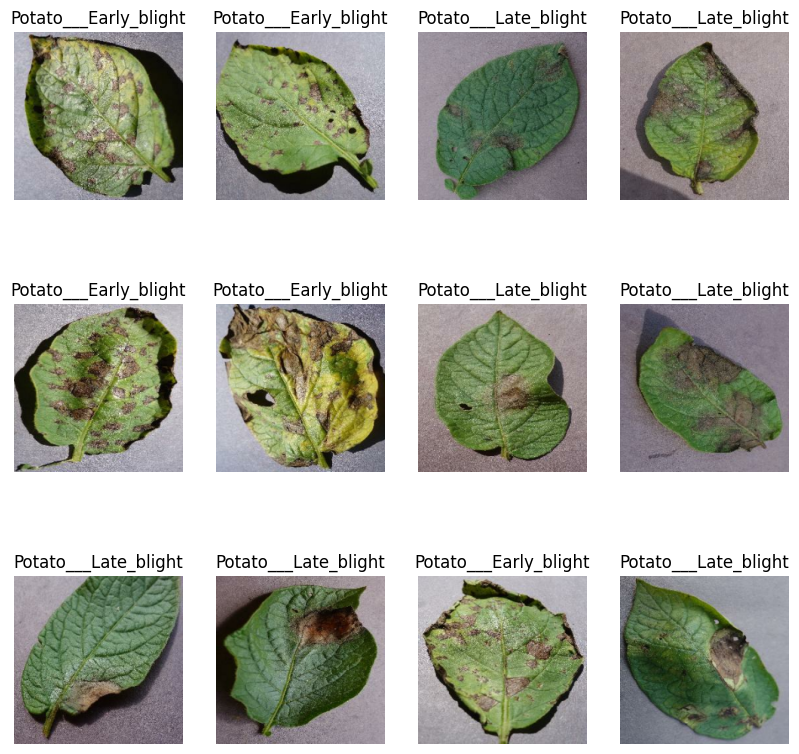

In [6]:
plt.figure(figsize=(10, 10))

for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

plt.show()

In [7]:
train_size = 0.8
train_set_size = len(dataset) * train_size

print(train_set_size)

54.400000000000006


In [8]:
train_ds = dataset.take(54)
train_ds_length = len(train_ds)

print(train_ds_length)

54


In [9]:
test_ds = dataset.skip(54)
test_ds_length = len(test_ds)

print(test_ds_length)

14


In [10]:
val_size = 0.1
val_set_size = len(dataset) * val_size

print(val_set_size)

6.800000000000001


In [11]:
val_ds = test_ds.take(7)
val_ds_length = len(val_ds)

print(val_ds_length)

7


In [12]:
test_ds = test_ds.skip(7)
test_ds_length = len(test_ds)

print(test_ds_length)

7


In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [14]:
print("Training Dataset Size: ", len(train_ds))
print("Validation Dataset Size: ", len(val_ds))
print("Test Dataset Size: ", len(test_ds))

Training Dataset Size:  54
Validation Dataset Size:  7
Test Dataset Size:  7


In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1.0/255,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.experimental.preprocessing.Rescaling(1.0/25)
])

In [18]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    layers.experimental.preprocessing.RandomContrast(0.2)
])

In [21]:
from tensorflow.keras.applications import MobileNetV2

IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    base_model,
    
    layers.GlobalAveragePooling2D(),
    
    layers.Dense(256, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [22]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               327936    
                                                                 
 dense_5 (Dense)             (None, 3)                

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 50s 598ms/step - loss: 0.7683 - accuracy: 0.7008 - val_loss: 0.6308 - val_accuracy: 0.7760
Epoch 2/50
54/54 [==============================] - 28s 509ms/step - loss: 0.6532 - accuracy: 0.7396 - val_loss: 0.5932 - val_accuracy: 0.8073
Epoch 3/50
54/54 [==============================] - 28s 515ms/step - loss: 0.6476 - accuracy: 0.7407 - val_loss: 0.7439 - val_accuracy: 0.6615
Epoch 4/50
54/54 [==============================] - 27s 507ms/step - loss: 0.6392 - accuracy: 0.7419 - val_loss: 0.6745 - val_accuracy: 0.7344
Epoch 5/50
54/54 [==============================] - 27s 508ms/step - loss: 0.5881 - accuracy: 0.7535 - val_loss: 0.7328 - val_accuracy: 0.6510
Epoch 6/50
54/54 [==============================] - 28s 516ms/step - loss: 0.5977 - accuracy: 0.7714 - val_loss: 0.7226 - val_accuracy: 0.6458
Epoch 7/50
54/54 [==============================] - 28s 510ms/step - loss: 0.5868 - accuracy: 0.7650 - val_loss: 0.7236 - val_accuracy: 0.6354

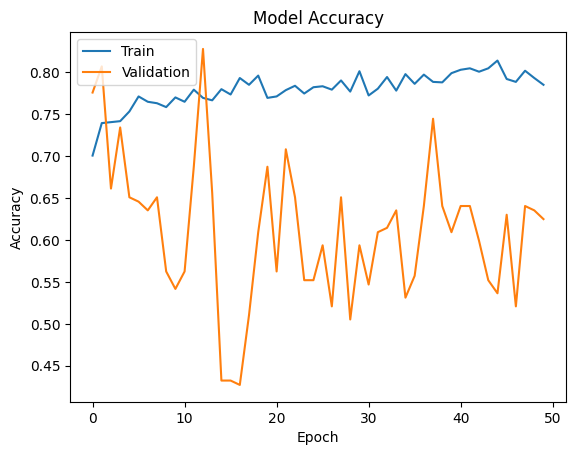

In [25]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
except NameError:
    print("Variable 'history' is not defined. Please make sure you have executed the cell that defines this variable.")

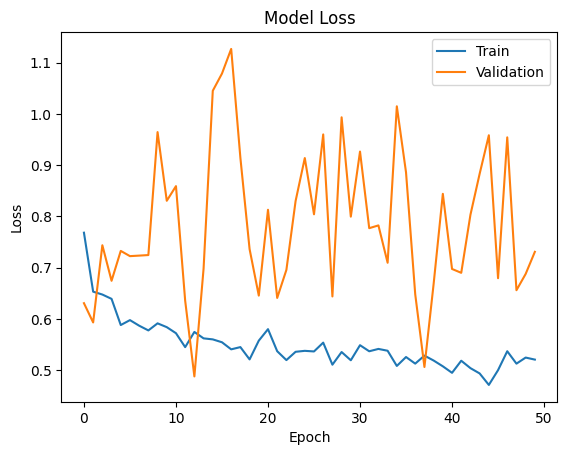

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

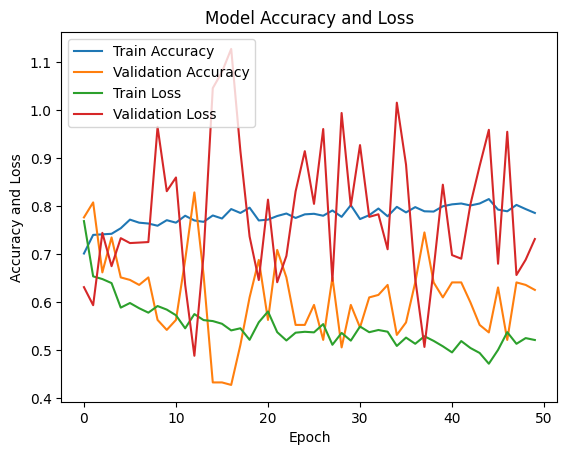

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [29]:
scores = model.evaluate(test_ds)

history.params

history.history['accuracy']

8/8 [==============================] - 1s 107ms/step - loss: 0.7355 - accuracy: 0.6406


[0.7008101940155029,
 0.7395833134651184,
 0.7407407164573669,
 0.7418981194496155,
 0.7534722089767456,
 0.7714120149612427,
 0.7650462985038757,
 0.7633101940155029,
 0.7586805820465088,
 0.7702546119689941,
 0.7650462985038757,
 0.7795138955116272,
 0.7696759104728699,
 0.7667824029922485,
 0.7800925970077515,
 0.7737268805503845,
 0.7934027910232544,
 0.7853009104728699,
 0.7962962985038757,
 0.7696759104728699,
 0.7714120149612427,
 0.7789351940155029,
 0.7841435074806213,
 0.7748842835426331,
 0.7824074029922485,
 0.7835648059844971,
 0.7795138955116272,
 0.7905092835426331,
 0.7771990895271301,
 0.8015046119689941,
 0.7725694179534912,
 0.7806712985038757,
 0.7945601940155029,
 0.7783564925193787,
 0.7980324029922485,
 0.7864583134651184,
 0.7974537014961243,
 0.7887731194496155,
 0.7881944179534912,
 0.7991898059844971,
 0.8032407164573669,
 0.8049768805503845,
 0.8009259104728699,
 0.8049768805503845,
 0.8142361044883728,
 0.7922453880310059,
 0.7887731194496155,
 0.8020833134

In [30]:
history.history['val_accuracy']

[0.7760416865348816,
 0.8072916865348816,
 0.6614583134651184,
 0.734375,
 0.6510416865348816,
 0.6458333134651184,
 0.6354166865348816,
 0.6510416865348816,
 0.5625,
 0.5416666865348816,
 0.5625,
 0.6875,
 0.828125,
 0.65625,
 0.4322916567325592,
 0.4322916567325592,
 0.4270833432674408,
 0.5104166865348816,
 0.609375,
 0.6875,
 0.5625,
 0.7083333134651184,
 0.6510416865348816,
 0.5520833134651184,
 0.5520833134651184,
 0.59375,
 0.5208333134651184,
 0.6510416865348816,
 0.5052083134651184,
 0.59375,
 0.546875,
 0.609375,
 0.6145833134651184,
 0.6354166865348816,
 0.53125,
 0.5572916865348816,
 0.640625,
 0.7447916865348816,
 0.640625,
 0.609375,
 0.640625,
 0.640625,
 0.5989583134651184,
 0.5520833134651184,
 0.5364583134651184,
 0.6302083134651184,
 0.5208333134651184,
 0.640625,
 0.6354166865348816,
 0.625]

In [31]:
history.history['loss']

[0.7683402299880981,
 0.6532489657402039,
 0.6476371884346008,
 0.6392004489898682,
 0.5881092548370361,
 0.5977045893669128,
 0.5868330597877502,
 0.5775964260101318,
 0.5914177894592285,
 0.5839665532112122,
 0.5721821784973145,
 0.5449987649917603,
 0.5746177434921265,
 0.5621055960655212,
 0.5601038336753845,
 0.5544740557670593,
 0.5406606197357178,
 0.5450558662414551,
 0.5210438966751099,
 0.5576239824295044,
 0.5800654888153076,
 0.537020206451416,
 0.5196816325187683,
 0.5358951687812805,
 0.5377542972564697,
 0.5365666151046753,
 0.5537619590759277,
 0.5107213854789734,
 0.5354233384132385,
 0.5193450450897217,
 0.5487673282623291,
 0.5368916988372803,
 0.5414986610412598,
 0.5379310250282288,
 0.5082613229751587,
 0.5256866812705994,
 0.5128019452095032,
 0.5284514427185059,
 0.5188219547271729,
 0.5075540542602539,
 0.49484241008758545,
 0.5184418559074402,
 0.5039696097373962,
 0.4936468303203583,
 0.4712317883968353,
 0.5000582337379456,
 0.5369926691055298,
 0.5127540230

In [33]:
history.history['val_loss']

[0.63075190782547,
 0.5931580066680908,
 0.7438706755638123,
 0.6744608879089355,
 0.7328085899353027,
 0.7225828170776367,
 0.7236176133155823,
 0.7247004508972168,
 0.9646827578544617,
 0.8306282162666321,
 0.8592322468757629,
 0.6356180310249329,
 0.487811416387558,
 0.6981432437896729,
 1.0453182458877563,
 1.078961730003357,
 1.1270149946212769,
 0.9145238995552063,
 0.736278235912323,
 0.6455835700035095,
 0.813071072101593,
 0.6409832835197449,
 0.6958022117614746,
 0.8302372097969055,
 0.9140501618385315,
 0.8042613863945007,
 0.9601476788520813,
 0.6439068913459778,
 0.9935590624809265,
 0.7996537089347839,
 0.9266602993011475,
 0.7771499156951904,
 0.7825601696968079,
 0.709691047668457,
 1.0150319337844849,
 0.8860230445861816,
 0.6480422616004944,
 0.5062308311462402,
 0.6684012413024902,
 0.8441916108131409,
 0.6975421905517578,
 0.6900165677070618,
 0.8033145070075989,
 0.883314847946167,
 0.9584729671478271,
 0.6794953346252441,
 0.9544296264648438,
 0.6560591459274292,


In [36]:
print("Accuracy: ", scores[1])
print("Loss: ", scores[0])

Accuracy:  0.640625
Loss:  0.735453724861145


In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

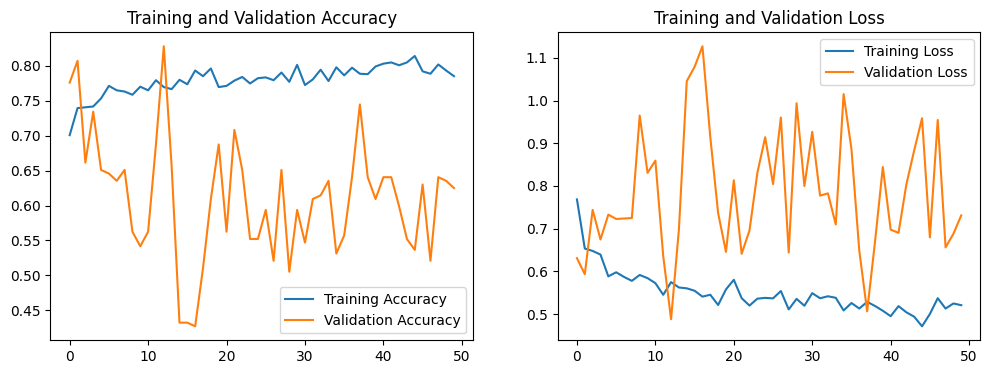

In [38]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

First image to predict
First image actual label: Potato___Early_blight
1/1 [==============================] - 0s 34ms/step
[9.9931192e-01 4.7228846e-04 2.1577108e-04]
Max Value: 0
Predicted Label: Potato___Early_blight


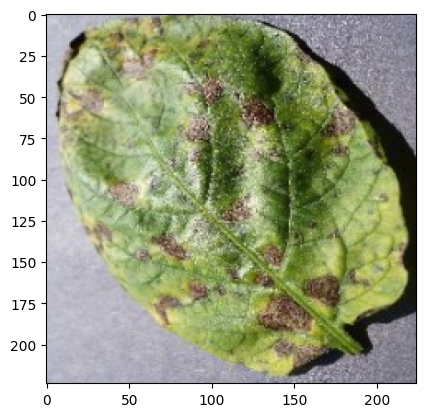

In [40]:
for image_batch, label_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0]
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print(batch_prediction[0])
    print("Max Value:", np.argmax(batch_prediction[0]))
    print("Predicted Label:", class_names[np.argmax(batch_prediction[0])])

In [41]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 24ms/step


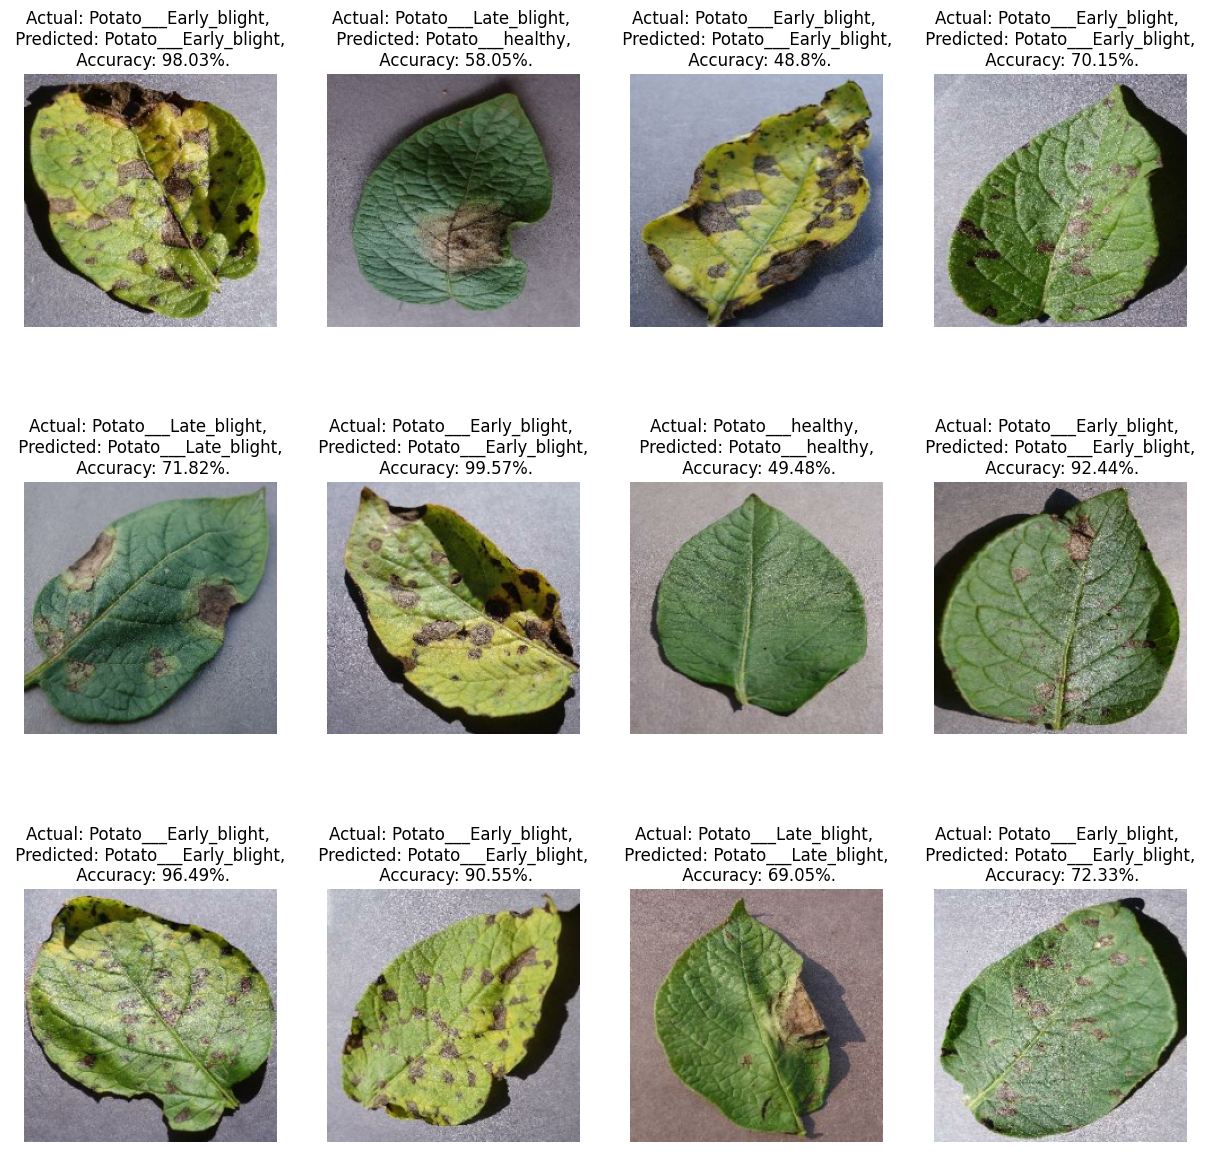

In [43]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Accuracy: {confidence}%.")  # Setting the title with actual class, predicted class, and confidence
        plt.axis("off")

In [44]:
print("Accuracy: ", scores[1] * 100)

Accuracy:  64.0625


In [45]:
from sklearn.metrics import f1_score, precision_score, recall_score

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

f1 = f1_score(y_true, y_pred, average='weighted') * 100
precision = precision_score(y_true, y_pred, average='weighted') * 100
recall = recall_score(y_true, y_pred, average='weighted') * 100

print("F1 Score: ", f1)
print("Precision Score: ", precision)
print("Recall Score: ", recall)

8/8 [==============================] - 2s 133ms/step
F1 Score:  43.668441980611824
Precision Score:  57.65543596560091
Recall Score:  39.453125


8/8 [==============================] - 1s 96ms/step


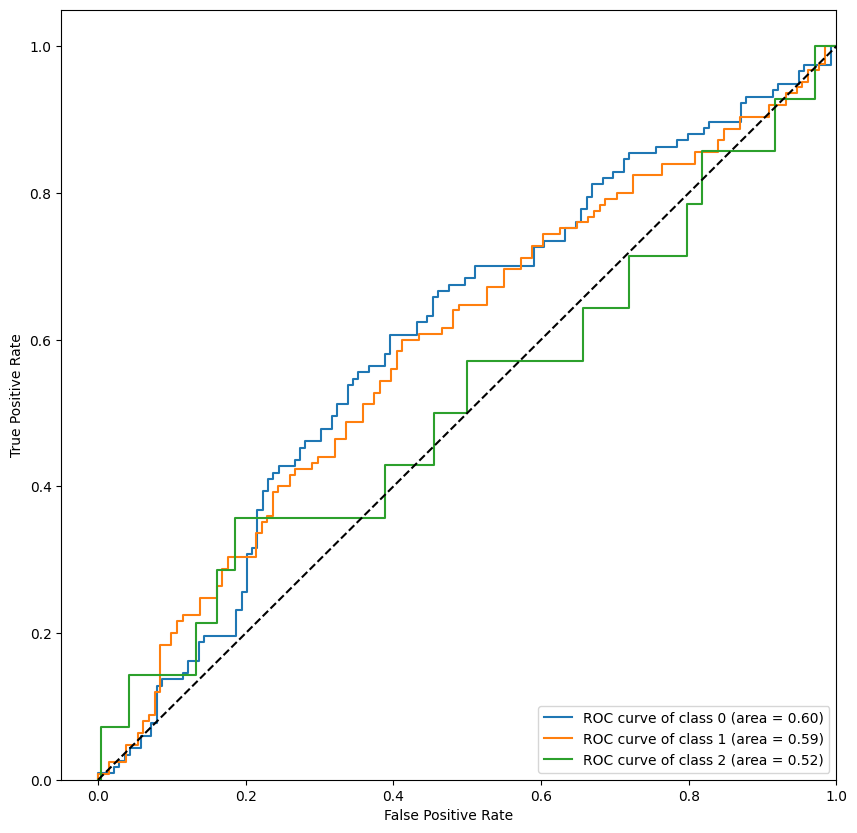

In [46]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test = label_binarize(y_true, classes=[0, 1, 2])
y_pred = model.predict(test_ds)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 10))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve of class {i} (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

8/8 [==============================] - 1s 95ms/step


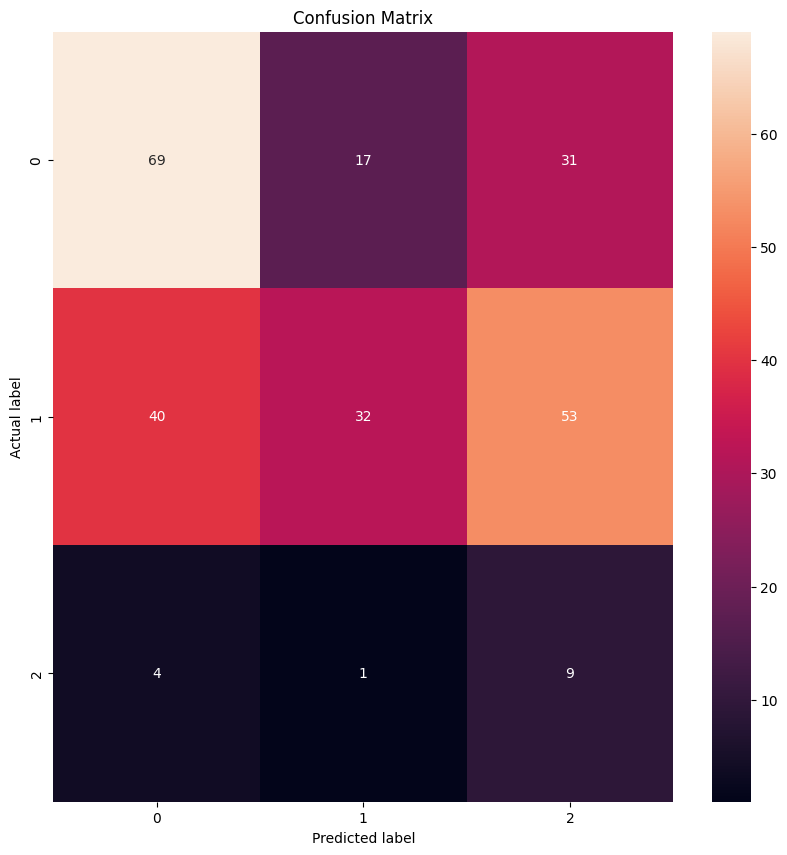

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [48]:
# Clear the TensorFlow session
tf.keras.backend.clear_session()